In [1]:
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def raw_read_input(day):
    with open(f'/Users/kris/Downloads/advent_of_code_2022/day{day}.txt') as file:
        return file.read()

def read_input(day, dtype=None):
    with open(f'/Users/kris/Downloads/advent_of_code_2022/day{day}.txt') as file:
        lines = [x.strip('\n') for x in file.readlines()]
        if dtype is not None:
            lines = [dtype(x) if x else None for x in lines]
        return lines
    
def read_matrix(day, dtype=np.int32):
    lines = read_input(day)
    lines = [[dtype(x) for x in line] for line in lines]
    return np.array(lines, dtype=dtype)

# Day 1

In [2]:
items = raw_read_input(day=1).split('\n\n')
elfs = [list(map(int, elf_items.strip().split('\n'))) for elf_items in items]
calories = sorted([sum(elf) for elf in elfs], reverse=True)
print(calories[0])
print(sum(calories[:3]))

69177
207456


# Day 2

In [3]:
def parse_match(match):
    player1, player2 = match.split()
    return (ord(player1) - ord('A'), ord(player2) - ord('X'))

def score_match(match):
    opponent, player = match
    if (opponent - player + 3) % 3 == 2:
        score = 6
    else:
        score = (opponent == player) * 3
    score += player + 1
    return score

def score_match2(match):
    opponent, result = match
    score = result * 3
    if result == 1:
        score += (opponent + 1)
    else:
        direction = 1 if result == 2 else -1 
        score += (opponent + direction + 3) % 3 + 1
    return score

matches = [parse_match(match) for match in read_input(day=2)]
print(sum(score_match(match) for match in matches))
print(sum(score_match2(match) for match in matches))

9759
12429


# Day 3

In [4]:
priorities = {chr(ord('a') + priority): priority + 1 for priority in range(26)}
priorities.update({chr(ord('A') + priority): priority + 27 for priority in range(26)})

backpacks = read_input(day=3)
commons = [set(x[:len(x) // 2]) & set(x[len(x) // 2:]) for x in backpacks]
print(sum([priorities[letter] for common in commons for letter in common]))

group_ids = [
    set(backpacks[index]) & set(backpacks[index + 1]) & set(backpacks[index + 2])
    for index in range(0, len(backpacks), 3)
]
print(sum([priorities[letter] for group in group_ids for letter in group]))

8088
2522


# Day 4

In [5]:
pairs = [x.split(',') for x in read_input(day=4)]
assignments = [(pair1.split('-'), pair2.split('-')) for pair1, pair2 in pairs]
assignments = [(tuple(map(int, pair1)), tuple(map(int, pair2))) for pair1, pair2 in assignments]
assignments = [sorted(assignment, key=lambda x: (x[0], -x[1])) for assignment in assignments]
print(sum(pair1[1] >= pair2[1] for pair1, pair2 in assignments))
print(sum(pair1[1] >= pair2[0] for pair1, pair2 in assignments))

532
854


# Day 5

In [6]:
import re
from copy import deepcopy

lines = read_input(day=5)
start_crates = [[] for _ in range(9)]
for index, line in enumerate(lines):
    if line[:2] == ' 1':
        index += 2
        break
    for letter_index in range(1, len(line), 4):
        letter = line[letter_index]
        if letter != ' ':
            start_crates[letter_index // 4].append(letter)
start_crates = [list(reversed(x)) for x in start_crates]

def move_crates(crates, orders, version):
    for order in orders:
        match = re.match(r'move (\d+) from (\d) to (\d)', order)
        count, start, end = map(int, match.groups())
        start -= 1
        end -= 1
        count = min(count, len(crates[start]))
        chunk = crates[start][-count:]
        if version == 9000:
            chunk = list(reversed(chunk))
        crates[start] = crates[start][:-count]
        crates[end].extend(chunk)
    print(''.join(crate[-1] for crate in crates))

move_crates(deepcopy(start_crates), lines[index:], version=9000)
move_crates(deepcopy(start_crates), lines[index:], version=9001)

JRVNHHCSJ
GNFBSBJLH


# Day 6

In [7]:
s = read_input(day=6)[0]
for index in range(4, len(s)):
    if len(set(list(s[index-4:index]))) == 4:
        break
print(index)
for index in range(4, len(s)):
    if len(set(list(s[index-14:index]))) == 14:
        break
print(index)

1876
2202


# Day 7

In [8]:
from typing import List, Dict, Optional
from dataclasses import dataclass

@dataclass
class File:
    name: str
    size: int

@dataclass
class Directory:
    name: str
    directories: Dict[str, 'Directory']
    files: List[File]
    parent: Optional['Directory']     
    _total_size: int

    def __init__(self, name, parent):
        self.name = name
        self.directories = {}
        self.files = []
        self.parent = parent
        self._total_size = -1
        
    def get_total_size(self):
        if self._total_size > 0:
            return self._total_size
        
        self._total_size = sum(directory.get_total_size() for directory in self.directories.values())
        self._total_size += sum(file.size for file in self.files)
        return self._total_size
        
lines = read_input(day=7)
root = Directory('/', parent=None)
current_dir = root

def ls(lines, index, current_dir):
    if len(current_dir.directories) or len(current_dir.files):
        return
    while index < len(lines) and not lines[index].startswith('$'):
        type_or_size, name = lines[index].split()
        if type_or_size == 'dir':
            current_dir.directories[name] = Directory(name, parent=current_dir)
        else:
            current_dir.files.append(File(name, int(type_or_size)))
        index += 1
    return index

def traverse(current_dir, answer):
    if current_dir.get_total_size() < 100000:
        answer.append(current_dir)
    for directory in current_dir.directories.values():
        traverse(directory, answer)

def traverse_big(current_dir, answer, check):
    if current_dir.get_total_size() >= check:
        answer.append(current_dir)
    for directory in current_dir.directories.values():
        traverse_big(directory, answer, check)

index = 1
while index < len(lines):
    command = lines[index]
    index += 1
    if command == '$ ls':
        index = ls(lines, index, current_dir)
    else:
        dir_name = command.split(' ')[-1]
        current_dir = (
            current_dir.parent 
            if dir_name == '..' else
            current_dir.directories[dir_name]
        )

answer = []
traverse(root, answer)
print(sum(x.get_total_size() for x in answer))

to_free = 30000000 - (70000000 - root.get_total_size())
answer = []
traverse_big(root, answer, to_free)
print(min(x.get_total_size() for x in answer))

1915606
5025657


# Day 8

In [9]:
matrix = read_matrix(day=8, dtype=np.int32)
print(
    sum(
        (
            i == 0
            or i == matrix.shape[0] - 1
            or j == 0
            or j == matrix.shape[1] - 1
            or np.max(matrix[i, :j]) < matrix[i, j]
            or np.max(matrix[i, j + 1 :]) < matrix[i, j]
            or np.max(matrix[:i, j]) < matrix[i, j]
            or np.max(matrix[i + 1 :, j]) < matrix[i, j]
        )
        for i in range(matrix.shape[0])
        for j in range(matrix.shape[1])
    )
)

print(
    max(
        np.product(
            [
                np.argmax(x >= matrix[i, j]) + 1 if np.any(x >= matrix[i, j]) else x.shape[0]
                for x in [matrix[:i, j][::-1], matrix[i + 1 :, j], matrix[i, :j][::-1], matrix[i, j + 1 :]]
            ]
        )
        for i in range(matrix.shape[0])
        for j in range(matrix.shape[1])
    )
)

1796
288120


# Day 9

In [10]:
moves = read_input(day=9)

def move_to_vector(move):
    direction, count = move.split(' ')
    direction = {
        'L': [0, -1],
        'U': [-1, 0],
        'R': [0, 1],
        'D': [1, 0]
    }[direction]
    return np.array(direction) * int(count)

visited = [set([(0, 0)]) for _ in range(10)]
knots = [np.array([0, 0]) for tail in range(10)]

for move in moves:
    vector = move_to_vector(move)
    knots[0] += vector
    still_moving = [True for _ in range(9)]
    while np.any(still_moving):
        for i in range(1, len(knots)):
            difference = knots[i - 1] - knots[i]
            if np.all(np.abs(difference) <= 1):
                still_moving[i - 1] = False
                continue
            difference = np.sign(knots[i - 1] - knots[i])
            knots[i] += difference
            visited[i].add(tuple(knots[i].tolist()))
print(len(visited[1]), len(visited[-1]))

5883 2367


# Day 10

10760


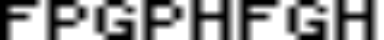

In [11]:
from PIL import Image
import cv2

instructions = read_input(day=10)
instructions = [
    [0] if instruction == 'noop' else [0, int(instruction.split(' ')[1])]
    for instruction in instructions]
instructions = [cycle for instruction in instructions for cycle in instruction]
instructions = np.concatenate([[1], np.cumsum(instructions) + 1])
print(np.sum(np.prod(np.stack([np.arange(1, len(instructions) + 1), instructions], axis=1)[19::40], axis=1)))

instructions = instructions[:-1].reshape((-1, 40))
image = np.abs(instructions - np.arange(40)) <= 1

image = cv2.resize((255 - image * 255).astype(np.uint8), (6 * 64, 40))
Image.fromarray(image, mode='L')

# Day 11

In [12]:
class Monkey:
    def __init__(self, monkey_lines):
        self.items = list(map(int, monkey_lines[1][len('  Starting items: '):].split(', ')))
        self.operation = monkey_lines[2][len('  Operation: new = '):]
        self.test_div = int(monkey_lines[3][len('  Test: divisible by '):])
        self.true_target = int(monkey_lines[4][len('    If true: throw to monkey '):])
        self.false_target = int(monkey_lines[5][len('    If false: throw to monkey '):])
        self.inspected_count = 0

lines = read_input(day=11)

def calculate_monkey_business(rounds, worry_dampener=True):
    monkeys = [
        Monkey(lines[index:index+8])
        for index in range(0, len(lines), 7)
    ]
    divisors = np.product([monkey.test_div for monkey in monkeys])

    for _ in range(rounds):
        for monkey_index, monkey in enumerate(monkeys):
            for old in monkey.items:
                new = eval(monkey.operation)
                new = new // 3 if worry_dampener else new % divisors
                target_monkey = (
                    monkey.true_target
                    if new % monkey.test_div == 0 else
                    monkey.false_target
                )
                monkeys[target_monkey].items.append(new)
                monkey.inspected_count += 1
            monkey.items.clear()
    by_inspections = list(sorted(monkey.inspected_count for monkey in monkeys))
    print(by_inspections[-1] * by_inspections[-2])

calculate_monkey_business(20, worry_dampener=True)
calculate_monkey_business(10000, worry_dampener=False)

76728
21553910156


# Day 12

In [13]:
from queue import PriorityQueue
from dataclasses import dataclass, field
from typing import Tuple
import numpy as np

lines = read_input(day=12)
matrix = np.array([list(x) for x in lines])
start_y, start_x = map(lambda x: x[0], np.where(matrix == 'S'))
end_y, end_x = map(lambda x: x[0], np.where(matrix == 'E'))
matrix[start_y, start_x] = 'a'
matrix[end_y, end_x] = 'z'
matrix = np.array([[ord(x[0]) - ord('a') for x in row] for row in matrix])

@dataclass(order=True)
class Item:
    distance: int
    steps: int = field(compare=False)
    coords: Tuple[int, int] = field(compare=False)
        
DIAGONAL_DIRECTIONS = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if dx !=0 or dy != 0]
DIRECTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

visited = {(start_y, start_x): 0}
queue = PriorityQueue()
queue.put(Item(steps=0, coords=(start_y, start_x), distance=abs(end_y - start_y + end_x - start_x)))

old_distance = 200
while queue.qsize() > 0:
    current = queue.get(block=False)
    y, x = current.coords
    
    for dy, dx in DIRECTIONS:
        new_y = y + dy
        new_x = x + dx
        if (0 > new_y or
            new_y >= matrix.shape[0] or
            0 > new_x or
            new_x >= matrix.shape[1] or
            matrix[new_y, new_x] - matrix[y, x] > 1):
            continue
        new_steps = 0 if matrix[new_y, new_x] == 0 else current.steps + 1
        if new_steps >= visited.get((new_y, new_x), np.inf):
            continue
        queue.put(Item(steps=new_steps, distance=(abs(end_y - new_y) + abs(end_x - new_x)), coords=(new_y, new_x)))
        visited[(new_y, new_x)] = new_steps
        
visited[(end_y, end_x)]

508

# Day 13

In [14]:
from functools import cmp_to_key
lines = read_input(day=13)

def is_ordered(left, right):
    if type(left) == int and type(right) == int:
        if left == right:
            return 0
        return -1 if left < right else 1
    if type(left) == int:
        left = [left]
    if type(right) == int:
        right = [right]
    for index in range(len(left)):
        if index == len(right):
            return 1
        comparison = is_ordered(left[index], right[index])
        if comparison == 0:
            continue
        return comparison
    if len(left) == len(right):
        return 0
    return -1

packets = [eval(line) for line in lines if line]
print(sum([
    index // 2 + 1
    for index in range(0, len(packets), 2)
    if is_ordered(packets[index], packets[index + 1]) == -1
]))

decoder1, decoder2 = [[2]], [[6]]
packets += [decoder1, decoder2]
packets = sorted(packets, key=cmp_to_key(is_ordered))
print((packets.index(decoder1) + 1) * (packets.index(decoder2) + 1))


4734
21836


# Day 14

In [15]:
import numpy as np
import cv2
from PIL import Image
from IPython.display import clear_output
import time

lines = read_input(day=14)
image = np.zeros((1010, 1010), dtype=np.int32)

for line in lines:
    steps = line.split(' -> ')
    steps = [tuple(map(int, step.split(','))) for step in steps]
    last_step = np.array(steps[0])
    for step in steps[1:]:
        step = np.array(step)
        diff = np.sign(step - last_step)
        while True:
            image[last_step[1], last_step[0]] = 1
            if np.all(step == last_step):
                break
            last_step += diff
        image[last_step[1], last_step[0]] = 1
        
def display_sand(image):
    miny, maxy, minx, maxx = 0, 178, 300, 700
    cropped_image = image[miny: maxy + 1, minx: maxx + 1]
    color_image = np.zeros((cropped_image.shape[0], cropped_image.shape[1], 3))
    color_image[cropped_image == 1] = [200, 200, 200]
    color_image[cropped_image == 2] = [255, 255, 0]
    pil_image = Image.fromarray(cv2.resize(color_image.astype(np.uint8), ((maxx - minx) * 5, (maxy - miny) * 5)), mode='RGB')
    display(pil_image)
    return pil_image

def simulate(image, end_on_floor, visualize=False):
    void_index = np.max(np.where(image == 1)[0])
    if not end_on_floor:
        image[void_index + 2, 0:1000] = 1
    round_index = 0
    frames = []
    while True:
        row, column = 0, 500
        if image[row, column] != 0:
            return round_index, frames
        while True:
            if row > void_index and end_on_floor:
                return round_index, frames
            if image[row + 1, column] == 0:
                row += 1
            elif image[row + 1, column - 1] == 0:
                row += 1
                column -= 1
            elif image[row + 1, column + 1] == 0:
                row += 1
                column += 1
            else:
                break
        image[row, column] = 2
        round_index += 1
        if visualize and round_index % (1 if end_on_floor else 100) == 0:
            clear_output(True)
            frames.append(display_sand(image))
answer1, frames1 = simulate(image.copy(), True, visualize=False)
answer2, frames2 = simulate(image.copy(), False, visualize=False)
print(answer1, answer2)

592 30367


# Day 15

In [16]:
import re
from tqdm.auto import tqdm

lines = read_input(day=15)
sensors = [
    tuple(map(int, re.match('Sensor at x=(-?\d+), y=(-?\d+): closest beacon is at x=(-?\d+), y=(-?\d+)', line).groups()))
    for line in lines
]
TARGET_ROW = 2000000
COORD_CAP = 4000000

def check(point, sensors):
    px, py = point
    if not (0 <= px <= COORD_CAP and 0 <= py <= COORD_CAP):
        return False
    matched = False
    for sensor in sensors:      
        sx, sy, bx, by = sensor
        distance = abs(bx - sx) + abs(by - sy)
        point_distance = abs(px - sx) + abs(py - sy)
        if point_distance <= distance:
            matched = True
            break
    if not matched:
        print('part 2:', px * 4000000 + py)
        return True
    return False
    

def solve(sensors):    
    segments = []
    beacons = set()
    found = False
    sensors = sorted(sensors, key=lambda x: abs(x[2] - x[0]) + abs(x[3] - x[1]))
    for sensor in tqdm(sensors):
        sx, sy, bx, by = sensor
        distance = abs(bx - sx) + abs(by - sy)
        for diff in range(distance + 2 if not found else 0):
            other_diff = (distance + 1) - diff
            if (check((sx + diff, sy + other_diff), sensors) or 
                check((sx - diff, sy + other_diff), sensors) or
                check((sx + diff, sy - other_diff), sensors) or
                check((sx - diff, sy - other_diff), sensors)):
                found = True
                break
        extra_distance = distance - abs(sy - TARGET_ROW)
        if extra_distance < 0:
            continue
        segments.append((sx - extra_distance, sx + extra_distance))
        if by == TARGET_ROW:
            beacons.add(bx)
    segments = sorted(segments, key=lambda x: (x[0], -x[1]))
    pixels = 0
    last = (-np.inf, -np.inf)
    for segment in segments:
        if segment[1] <= last[1]:
            continue
        last = max(last[1] + 1, segment[0]), segment[1]
        pixels += last[1] - last[0] + 1
        for beacon in beacons:
            if last[0] <= beacon <= last[1]:
                pixels -= 1    
        
    return pixels
        
solve(sensors)

  0%|          | 0/23 [00:00<?, ?it/s]

part 2: 12630143363767


4919281

# Day 16

In [17]:
import re
from tqdm.auto import tqdm
import itertools

lines = read_input(day=16)
valves = {}
valve_neighbors = {}
for line in lines:
    match = re.match(r'Valve (\w+) has flow rate=(\d+); tunnel[s]? lead[s]? to valve[s]? (.+)', line)
    origin, flow, connections = match.groups()
    valves[origin] = int(flow)
    valve_neighbors[origin] = connections.split(', ')
    
non_zero = [valve for valve, value in valves.items() if value > 0]
def min_distance(current, target, visited, distance, best):
    if current == target:
        return distance if best > distance else best
    for neighbor in valve_neighbors[current]:
        if neighbor in visited:
            continue
        best = min_distance(neighbor, target, visited.copy() | {neighbor}, distance + 1, best)
        
    return best

distances = {
    (a, b): min_distance(a, b, {a}, 0, 1000)
    for index, a in enumerate(non_zero + ['AA'])
    for b in (non_zero + ['AA'])[index + 1:]
}
distances.update({(b, a): value for (a, b), value in distances.items()})

def traverse(current, remaining, time_left, score, flow, best):
    potential_score = score + flow * time_left
    if potential_score > best:
        best = potential_score
    if not remaining:
        return best
    
    potential_time_left = time_left
    potential_opens = sorted(list(remaining), key=lambda x: valves[x], reverse=True)
    for potential_open in potential_opens:
        potential_time_left -= 2
        potential_score += valves[potential_open] * potential_time_left
        if potential_time_left <= 0:
            break
    if best >= potential_score + 50:
        return best
    for next_valve in potential_opens:
        distance_to = distances[(current, next_valve)]
        if time_left <= distance_to:
            continue
        best = traverse(
            next_valve,
            remaining.copy().difference({next_valve}),
            time_left - (distance_to + 1),
            score + (distance_to + 1) * flow,
            flow + valves[next_valve],
            best
        )
    return best

def two_partitions(S):
    res_list = []
    for l in range(0,int(len(S)/2)+1):
        combis = set(itertools.combinations(S,l))
        for c in combis:
            res_list.append((sorted(list(c)), sorted(list(S-set(c)))))
    return res_list

print(traverse('AA', set(non_zero), 30, 0, 0, 0))
best = 0
for a, b in tqdm(two_partitions(set(non_zero))):
    score_a = traverse('AA', set(a), 26, 0, 0, 0)
    score_b = traverse('AA', set(b), 26, 0, 0, 0)
    if best < score_a + score_b:
        best = score_a + score_b
print(best)

1896


  0%|          | 0/16384 [00:00<?, ?it/s]

2576


# Day 17

In [18]:
flows = read_input(day=17)[0]
SHAPES = [
    np.array(x, dtype=bool)
    for x in [
        [[1, 1, 1, 1]],
        [[0, 1, 0],
         [1, 1, 1],
          [0, 1, 0]],
        [[0, 0, 1],
         [0, 0, 1],
         [1, 1, 1]],
        [[1],
         [1],
         [1],
         [1]],
        [[1, 1],
         [1, 1]]
    ]
]
last_cycle = None
last_height = None
final_step = None
TARGET_ROUND = 1000000000000

tetris = np.zeros((0, 7), dtype=bool)
flow_index = 0
for shape_index in range(11000):
    ys, xs = np.where(tetris == True)
    max_height = min(ys, default=0)
    if shape_index == 2022:
        print('part1', tetris.shape[0] - max_height)
    if shape_index == final_step:
        print('part2', tetris.shape[0] - max_height + extra_score)
        break
    new_shape = SHAPES[shape_index % len(SHAPES)]
    to_expand = (new_shape.shape[0] + 3) - max_height
    if to_expand >= 0:
        tetris = np.pad(tetris, ((to_expand, 0), (0, 0)))
    else:
        tetris = tetris[abs(to_expand) :]
    y_shape, x_shape = 0, 2
    while True:
        direction = 1 if flows[flow_index] == '>' else -1
        flow_index += 1
        if flow_index == len(flows):
            if last_cycle is not None:
                cycle_size = shape_index - last_cycle
                extra_score = (
                    (TARGET_ROUND - shape_index) // cycle_size * (tetris.shape[0] - max_height - last_height)
                )
                final_step = (TARGET_ROUND - shape_index) % cycle_size + shape_index
            if last_cycle is None:
                last_cycle = shape_index
                last_height = tetris.shape[0] - max_height
            flow_index = 0
        if 0 <= x_shape + direction and x_shape + direction + new_shape.shape[1] <= tetris.shape[1]:
            if not np.any(
                tetris[
                    y_shape : y_shape + new_shape.shape[0],
                    x_shape + direction : x_shape + direction + new_shape.shape[1],
                ]
                & new_shape
            ):
                x_shape += direction
        if (y_shape + 1 + new_shape.shape[0] > tetris.shape[0]) or (
            np.any(
                tetris[y_shape + 1 : y_shape + 1 + new_shape.shape[0], x_shape : x_shape + new_shape.shape[1]]
                & new_shape
            )
        ):
            tetris[y_shape : y_shape + new_shape.shape[0], x_shape : x_shape + new_shape.shape[1]] |= new_shape
            break
        y_shape += 1

part1 3083
part2 1532183908048


# Day 18

In [19]:
from collections import defaultdict
lines = read_input(day=18)

cubes = {tuple(map(int, cube.split(','))) for cube in lines}
DIRECTIONS = [
    np.array((x, y, z))
    for x in range(-1, 2)
    for y in range(-1, 2)
    for z in range(-1, 2)
    if abs(x) + abs(y) + abs(z) == 1
]

min_coord, max_coord = np.min(list(cubes)) - 1, np.max(list(cubes)) + 1
visited = set([(min_coord, min_coord, min_coord)])
queue = [np.array((min_coord, min_coord, min_coord))]
while queue:
    current, *queue = queue
    if np.any([
        coord < min_coord or coord > max_coord
        for coord in current
    ]):
        continue
    for direction in DIRECTIONS:
        new = current + direction   
        new_key = tuple(new.tolist())
        if new_key in cubes or new_key in visited:
            continue
        visited.add(new_key)
        queue.append(new)

part1, part2 = 0, 0
for cube in cubes:
    for direction in DIRECTIONS:
        side_cube = tuple((np.array(np.array(cube) + direction)).tolist())
        part1 += side_cube not in cubes
        part2 += side_cube in visited
print(part1, part2)

4460 2498


# Day 19

In [20]:
from dataclasses import dataclass
import re
from functools import lru_cache, wraps
from tqdm.auto import tqdm
from frozendict import frozendict

def freezeargs(func):
    @wraps(func)
    def wrapped(*args, **kwargs):
        args = tuple([frozendict(arg) if isinstance(arg, dict) else arg for arg in args])
        kwargs = {k: frozendict(v) if isinstance(v, dict) else v for k, v in kwargs.items()}
        return func(*args, **kwargs)
    return wrapped


@dataclass(eq=True, frozen=True)
class Blueprint:
    index: int
    ore: int
    clay: int
    obsidian_ore: int
    obsidian_clay: int
    geode_ore: int
    geode_obsidian: int
        
    @lru_cache
    def max_material(self, material):
        if material == 'ore':
            return max(self.ore, self.clay, self.geode_ore, self.obsidian_ore)
        if material == 'clay':
            return self.obsidian_clay
        if material == 'obsidian':
            return self.geode_obsidian
        if material == 'geode':
            return 1000
        raise ValueError('Invalid material: ' + material)
    
    @lru_cache
    def demand(self, robot):
        if robot == 'ore':
            return {'ore': self.ore}
        if robot == 'clay':
            return {'ore': self.clay}
        if robot == 'obsidian':
            return {'ore': self.obsidian_ore, 'clay': self.obsidian_clay}
        if robot == 'geode':
            return {'ore': self.geode_ore, 'obsidian': self.geode_obsidian}
        raise ValueError('Invalid robot: ' + robot)
    
    def has_enough(self, supply, robot):
        demand = self.demand(robot)
        return all(supply[material] >= demand[material] for material in demand)
    
        
regex_match = r'Blueprint (\d+): Each ore robot costs (\d+) ore\. Each clay robot costs (\d+) ore. Each obsidian robot costs (\d+) ore and (\d+) clay\. Each geode robot costs (\d+) ore and (\d+) obsidian\.'
lines = read_input(day=19)
blueprints = [Blueprint(*map(int, re.match(regex_match, line).groups())) for line in lines]

def run_score(blueprint, production, supply, time_left, robot_type):  
    demand = blueprint.demand(robot_type)
    new_production = {material: production[material] + int(robot_type == material) for material in production}
    new_production = {material: min(new_production[material], blueprint.max_material(material)) for material in new_production}
    
    new_supply = {material: supply[material] - demand.get(material, 0) + production[material] for material in supply}
    for material in new_supply:
        if production[material] >= blueprint.max_material(material):
            new_supply[material] = blueprint.max_material(material)
    
    return score_blueprint(blueprint, new_production, new_supply, time_left)


@freezeargs
@lru_cache(maxsize=None)
def score_blueprint(blueprint, production, supply, time_left):
    scores = []
    for robot_to_build in ['geode', 'obsidian', 'clay', 'ore']:
        if (robot_to_build == 'obsidian' and production['clay'] == 0 or 
            robot_to_build == 'geode' and production['obsidian'] == 0):
            continue
        if supply[robot_to_build] + time_left * production[robot_to_build] >= blueprint.max_material(robot_to_build) * time_left:
            continue
        current_supply = supply.copy()
        new_time_left = time_left
        while new_time_left > 0 and not blueprint.has_enough(current_supply, robot_to_build):
            current_supply = {material: current_supply[material] + production[material] for material in current_supply}
            new_time_left -= 1
        
        scores.append(current_supply['geode'] if new_time_left == 0 else run_score(
            blueprint, production, current_supply, new_time_left - 1, robot_to_build))
    scores.append(supply['geode'] + time_left * production['geode'])
    return max(scores)

start_production = {
    'ore': 1,
    'clay': 0,
    'obsidian': 0,
    'geode': 0
}
start_supply = {material: 0 for material in start_production}

results = [
    blueprint.index * score_blueprint(blueprint, start_production, start_supply, 24)
    for blueprint in tqdm(blueprints)
]
print(sum(results))

results = [
    score_blueprint(blueprint, start_production.copy(), start_supply.copy(), 32)
    for blueprint in tqdm(blueprints[:3])
]
print(np.product(results))

[4, 6, 3, 0, 5]


  0%|          | 0/30 [00:00<?, ?it/s]

1177


  0%|          | 0/3 [00:00<?, ?it/s]

62744


# Day 20

In [21]:
lines = read_input(day=20)
numbers_part1 = [[int(number), index] for index, number in enumerate(lines)]
numbers_part2 = [[int(number) * 811589153, index] for index, number in enumerate(lines)]

def decrypt_coordinates(numbers, rounds):
    rotations = len(numbers) - 1
    for _ in range(rounds):
        index = 0
        next_index = 0
        while next_index < len(numbers):
            move_by, original_order = numbers[index]
            if original_order != next_index:
                index = (index + 1) % len(numbers)
                continue
            final_index = (index + move_by) % rotations
            if move_by != 0 and final_index == 0:
                final_index = rotations

            next_index += 1
            if final_index == index:
                continue
            if final_index < index:
                numbers = numbers[:final_index] + [numbers[index]] + numbers[final_index: index] + numbers[index + 1:]
            else:
                numbers = numbers[:index] + numbers[index + 1: final_index + 1] + [numbers[index]] + numbers[final_index + 1:]

    index_of = [x[0] for x in numbers].index(0)
    return numbers[(index_of + 1000) % len(numbers)][0] + numbers[(index_of + 2000) % len(numbers)][0] + numbers[(index_of + 3000) % len(numbers)][0]
print(decrypt_coordinates(numbers_part1, 1))
print(decrypt_coordinates(numbers_part2, 10))

7153
6146976244822


# Day 21

In [22]:
import operator

OPERATORS = {'*': operator.mul, '-': operator.sub, '+': operator.add, '/': operator.truediv}
lines = read_input(day=21)
monkey_rules = dict([monkey.split(': ') for monkey in lines])

def calc(monkey, monkey_values):
    if monkey in monkey_values:
        return monkey_values[monkey]
    try:
        left_monkey, operation, right_monkey = monkey_rules[monkey].split(' ')
    except:
        monkey_values[monkey] = [int(monkey_rules[monkey]), 0]
        return monkey_values[monkey]
                                 
    left_monkey = calc(left_monkey, monkey_values)
    right_monkey = calc(right_monkey, monkey_values)
    if operation in ['/', '*']:
        if right_monkey[1] == 0:
            right_monkey[1] = right_monkey[0]
        elif left_monkey[1] == 0:
            left_monkey[1] = left_monkey[0]
    monkey_values[monkey] = [
        OPERATORS[operation](left_monkey[index], right_monkey[index])
        for index in [0, 1]
    ]
    return monkey_values[monkey]

print(int(calc('root', {})[0]))

left, _, right = monkey_rules['root'].split(' ')
monkey_values = {'humn': [0, 1]}
left, right = calc(left, monkey_values), calc(right, monkey_values)
print(int((right[0] - left[0]) / left[1]))

309248622142100
3757272361782


# Day 22

In [23]:
import numpy as np
import re
import sys
np.set_printoptions(threshold=sys.maxsize)
lines = read_input(day=22)

*map_lines, _, instructions = lines
max_line = max(len(x) for x in map_lines)
matrix = np.array([list(x) + [' '] * (max_line - len(x)) for x in map_lines])
instructions = list(zip(re.split(r'\d+', instructions)[1:], re.split(r'[LR]', instructions)))
DIRECTIONS = [[0, 1], [1, 0], [0, -1], [-1, 0]]

y, x, facing = 0, np.argmax(matrix[0] == '.'), 0
for turn, steps in instructions:
    for _ in range(int(steps)):
        new_y, new_x = (y + DIRECTIONS[facing][0]) % matrix.shape[0], (x + DIRECTIONS[facing][1]) % matrix.shape[1]
        while matrix[new_y, new_x] == ' ':
            new_y, new_x = (new_y + DIRECTIONS[facing][0]) % matrix.shape[0], (new_x + DIRECTIONS[facing][1]) % matrix.shape[1]
        if matrix[new_y, new_x] == '#':
            break
        y, x = new_y, new_x
    if turn:
        facing = (facing + (1 if turn == 'R' else -1)) % 4

print('Part 1:', (y + 1) * 1000 + (x + 1) * 4 + facing)

cube_neighbors = [
    [(4, 0), (3, 0), (1, 2), (2, 3)],
    [(5, 0), (2, 0), (0, 2), (3, 3)],
    [(5, 1), (4, 0), (0, 1), (1 ,0)],
    [(4, 1), (5, 0), (1, 1), (0, 0)],
    [(5, 2), (3, 3), (0, 0), (2, 0)],
    [(4, 2), (2, 3), (1, 0), (3, 0)]
]
cube_offsets = [
    (100, 0),
    (0, 50),
    (50, 50),
    (150, 0),
    (100, 50),
    (0, 100),
]
cube = [matrix[y:y+50, x:x+50] for y, x in cube_offsets]
y, x, cube_index, facing, orientation = 0, 0, 1, 0, 0
current_cube = cube[cube_index]

for turn, steps in instructions:
    for _ in range(int(steps)):
        new_y, new_x = (y + DIRECTIONS[facing][0]), (x + DIRECTIONS[facing][1])
        if new_y < 0:
            new_direction = 3
        elif new_x < 0:
            new_direction = 2
        elif new_y == current_cube.shape[0]:
            new_direction = 1
        elif new_x == current_cube.shape[1]:
            new_direction = 0
        else:
            new_direction = -1
        if new_direction >= 0:
            new_x %= 50
            new_y %= 50
            next_cube_index, new_cube_orientation = cube_neighbors[cube_index][(new_direction - orientation) % 4]
            new_cube_orientation = (new_cube_orientation + orientation) % 4
            new_cube = np.rot90(cube[next_cube_index], k=-new_cube_orientation, axes=(0, 1))
            
            if new_cube[new_y, new_x] == '#':
                break
            cube_index = next_cube_index
            current_cube = new_cube
            orientation = new_cube_orientation
            
        if current_cube[new_y, new_x] == '#':
            break
        y, x = new_y, new_x
    if turn:
        facing = (facing + (1 if turn == 'R' else -1)) % 4

for times in range(orientation):
    y, x = 49 - x, y
facing += orientation

print('Part 2:', (y + cube_offsets[cube_index][0] + 1) * 1000 + (x + cube_offsets[cube_index][1] + 1) * 4 + facing)

Part 1: 27436
Part 2: 15426


# Day 23

In [24]:
lines = read_input(day=23)
matrix = np.array([[x == '#' for x in line] for line in lines])
elves = np.array(list(zip(*np.where(matrix))))

DIRECTIONS = np.array([
    [-1, 0], [-1, -1], [-1, 1],
    [1, 0], [1, -1], [1, 1],
    [0, -1], [-1, -1], [1, -1],
    [0, 1], [-1, 1], [1, 1],
])

round_index = 0
while True:
    if round_index == 10:
        miny, maxy, minx, maxx = np.min(elves[:, 0]), np.max(elves[:, 0]), np.min(elves[:, 1]), np.max(elves[:, 1])
        print('Part 1:', (1 + maxy - miny) * (1 + maxx - minx) - elves.shape[0])
    proposals = (elves[:, None, :] + DIRECTIONS[None, ...]).reshape((-1, 2))
    elf_positions = set([tuple(x) for x in elves])
    new_squares = np.array([tuple(x) in elf_positions for x in proposals])
    allowed_directions = np.all(new_squares.reshape(-1, 4, 3) == False, axis=2)
    all_allowed_indices = np.where(np.all(allowed_directions == True, axis=1))[0]
    if all_allowed_indices.shape[0] == elves.shape[0]:
        print('Part 2:', round_index + 1)
        break
    allowed_directions[all_allowed_indices, :] = False
    allowed_directions_and_stay = np.concatenate([allowed_directions, np.array([True] * allowed_directions.shape[0])[..., None]], axis=1)
    chosen_action = np.argmax(allowed_directions_and_stay, axis=1)
    
    proposals = proposals.reshape((-1, DIRECTIONS.shape[0], 2))[:, ::3]
    chosen_square = np.concatenate([proposals, elves[:, None, :]], axis=1)[np.arange(chosen_action.shape[0]), chosen_action, :]
    
    uniques, reverse_index, counts = np.unique(chosen_square, return_counts=True, return_inverse=True, axis=0)
    staying_mask = np.array(counts[reverse_index]) != 1
    chosen_square[staying_mask] = elves[staying_mask]
    elves = chosen_square
    
    DIRECTIONS = np.roll(DIRECTIONS, shift=-3, axis=0)
    round_index += 1

Part 1: 4045
Part 2: 963


# Day 24

In [25]:
from queue import PriorityQueue
from dataclasses import dataclass, field
from typing import Tuple
import numpy as np

lines = read_input(day=24)
facing_chart = {char: facing for facing, char in enumerate(['.', '>', 'v', '<', '^'])}
matrix = np.array([[facing_chart[char] for char in line[1:-1]] for line in lines[1:-1]])
blizzards = np.array([list(x) for x in zip(*np.where(matrix > 0))])
blizzards_per_round = [(blizzards, set([tuple(x) for x in blizzards]))]
DIRECTIONS = np.array([(0, 1), (1, 0), (0, -1), (-1, 0)])
blizzards_facing = DIRECTIONS[matrix[blizzards[: ,0], blizzards[:, 1]] - 1]

def get_blizzard_per_round(round_index):
    if round_index < len(blizzards_per_round):
        return blizzards_per_round[round_index]
    current, _ = blizzards_per_round[round_index - 1]
    current +=  blizzards_facing
    
    current[:, 0] = np.mod(current[:, 0], matrix.shape[0])
    current[:, 1] = np.mod(current[:, 1], matrix.shape[1])
    blizzards_per_round.append((current, set([tuple(x) for x in current])))
    return blizzards_per_round[round_index]

start_y, start_x = (-1, 0)
end_y, end_x = (matrix.shape[0], matrix.shape[1] - 1)

@dataclass(order=True)
class Item:
    distance: int
    steps: int = field(compare=False)
    coords: Tuple[int, int] = field(compare=False)
        
def get_distance(start_y, start_x, end_y, end_x, start_turn):
    queue = PriorityQueue()
    end_distance = abs(end_y - start_y + end_x - start_x)
    queue.put(Item(steps=start_turn, coords=(start_y, start_x), distance=end_distance))
    visited = set()

    while queue.qsize() > 0:
        current = queue.get(block=False)
        _, blizzards = get_blizzard_per_round(current.steps + 1)
        if current.coords not in blizzards:
            queue.put(Item(steps=current.steps + 1, coords=current.coords, distance=current.distance + 1))

        for dy, dx in DIRECTIONS:
            new_y, new_x = current.coords[0] + dy, current.coords[1] + dx
            distance_to_end = abs(end_y - new_y) + abs(end_x - new_x)
            if distance_to_end == 0:
                return current.steps + 1

            if (not (0 <= new_y < matrix.shape[0] and 0 <= new_x < matrix.shape[1]) or
                (new_y, new_x) in blizzards or
                (current.steps + 1, new_y, new_x) in visited):
                continue

            visited.add((current.steps + 1, new_y, new_x))
            queue.put(Item(
                steps=current.steps + 1,
                coords=(new_y, new_x),
                distance=current.steps + 1 + distance_to_end
            ))
            
part1 = get_distance(start_y, start_x, end_y, end_x, 0)
mid = get_distance(end_y, end_x, start_y, start_x, part1)
part2 = get_distance(start_y, start_x, end_y, end_x, mid)
print(part1, part2)

264 789


# Day 25

In [41]:
lines = read_input(day=25)
SNAFU_DIGITS = {
    '2': 2,
    '1': 1,
    '0': 0,
    '-': -1,
    '=': -2
}
SNAFU_DIGITS_REVERSED = {digit: snafu for snafu, digit in SNAFU_DIGITS.items()}
BASE_DIGIT = 5

def to_dec(snafu):
    multiplier = 1
    result = 0
    for snafu_digit in reversed(snafu):
        result += multiplier * SNAFU_DIGITS[snafu_digit]
        multiplier *= BASE_DIGIT
    return result

def to_snafu(number):
    result = ''
    leftover = 0
    while number:
        current = (number % BASE_DIGIT) + leftover
        if current > 2:
            current -= BASE_DIGIT
            leftover = 1
        else:
            leftover = 0
        result = SNAFU_DIGITS_REVERSED[current] + result
        number //= BASE_DIGIT
    return result
        
        
total = sum(to_dec(line) for line in lines)
print(to_snafu(total))

2-1-110-=01-1-0-0==2
